In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Define the path to your dataset directory
data_dir = r'C:\Users\Govind Raina\Documents\Face Recognition'

# Create an ImageDataGenerator for training and validation sets with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

In [3]:
# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data without augmentation
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 22921 images belonging to 2 classes.
Found 5729 images belonging to 2 classes.


In [4]:
# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers with dropout regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [5]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping]  # Use early stopping callback
)

Epoch 1/10


C:\Users\Govind Raina\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


716/716 ━━━━━━━━━━━━━━━━━━━━ 676s 930ms/step - accuracy: 0.9543 - loss: 0.1881 - val_accuracy: 0.9647 - val_loss: 0.0690
Epoch 2/10
  1/716 ━━━━━━━━━━━━━━━━━━━━ 4:06 345ms/step - accuracy: 1.0000 - loss: 0.0095

C:\Users\Govind Raina\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 688s 958ms/step - accuracy: 0.9719 - loss: 0.0627 - val_accuracy: 0.9609 - val_loss: 0.0774
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 0.0247 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 671s 934ms/step - accuracy: 0.9745 - loss: 0.0564 - val_accuracy: 0.9653 - val_loss: 0.0743


In [6]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

180/180 ━━━━━━━━━━━━━━━━━━━━ 131s 729ms/step - accuracy: 0.9631 - loss: 0.0675
Validation Loss: 0.07030856609344482
Validation Accuracy: 0.9624716639518738


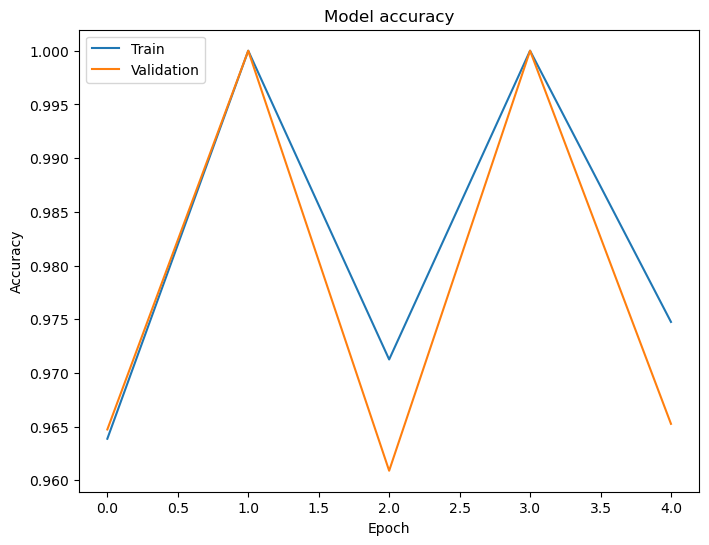

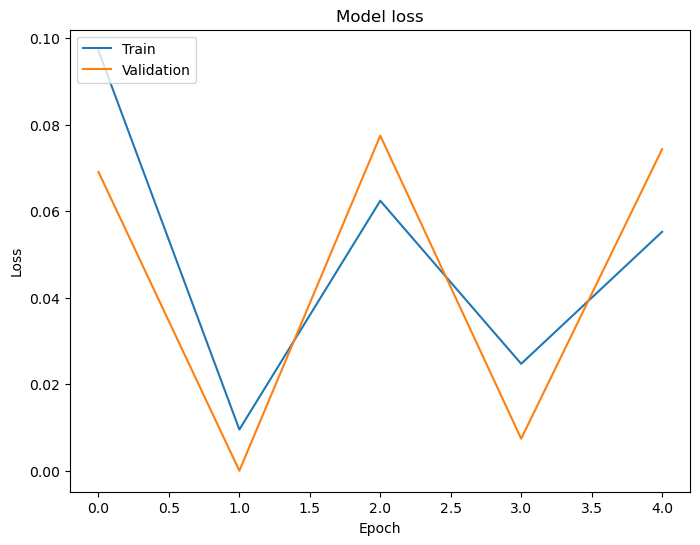

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('face_recognition_model_with_overfitting_strategy.h5')
